## Load Data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

items_df = pd.read_csv('data/items.csv')
shops_df = pd.read_csv('data/shops.csv')

icats_df = pd.read_csv('data/item_categories.csv')
train_df = pd.read_csv('data/sales_train.csv.gz', compression='gzip', header=0, sep=',', quotechar='"')
smpsb_df = pd.read_csv('data/sample_submission.csv.gz', compression='gzip', header=0, sep=',', quotechar='"')
test_df  = pd.read_csv('data/test.csv.gz', compression='gzip', header=0, sep=',', quotechar='"')
# Any results you write to the current directory are saved as output.

## Map Items Categorries
Map Cattegories to more narrow ones

In [2]:
l = list(icats_df.item_category_name)
l_cat = l

for ind in range(1,8):
    l_cat[ind] = 'Access'

for ind in range(10,18):
    l_cat[ind] = 'Consoles'

for ind in range(18,25):
    l_cat[ind] = 'Consoles Games'

for ind in range(26,28):
    l_cat[ind] = 'phone games'

for ind in range(28,32):
    l_cat[ind] = 'CD games'

for ind in range(32,37):
    l_cat[ind] = 'Card'

for ind in range(37,43):
    l_cat[ind] = 'Movie'

for ind in range(43,55):
    l_cat[ind] = 'Books'

for ind in range(55,61):
    l_cat[ind] = 'Music'

for ind in range(61,73):
    l_cat[ind] = 'Gifts'

for ind in range(73,79):
    l_cat[ind] = 'Soft'


icats_df['cats'] = l_cat
icats_df.head()

,item_category_name,item_category_id,cats
0,PC - Гарнитуры/Наушники,0,PC - Гарнитуры/Наушники
1,Аксессуары - PS2,1,Access
2,Аксессуары - PS3,2,Access
3,Аксессуары - PS4,3,Access
4,Аксессуары - PSP,4,Access


## Pre-Train

In [3]:
train_df['date'] = pd.to_datetime(train_df.date,format="%d.%m.%Y")
train_df.head()


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


## Aggregate Data for Mean Encoding

In [6]:
from itertools import product
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
sales = train_df
for block_num in sales['date_block_num'].unique():
    cur_shops = sales[sales['date_block_num']==block_num]['shop_id'].unique()
    cur_items = sales[sales['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

#turn the grid into pandas dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

#get aggregated values for (shop_id, item_id, month)
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})

#fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
#join aggregated data to the grid
all_data = pd.merge(grid,gb,how='left',on=index_cols).fillna(0)
#sort the data
all_data.sort_values(['date_block_num','shop_id','item_id'],inplace=True)

/Users/juanzinser/Workspace/advance-machine-learning/venv/lib/python3.6/site-packages/pandas/core/groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


## Mean Encoding

In [77]:
alpha = 10
globalmean  = 1.24
nrows = all_data.groupby('item_id')['target'].count()
means = all_data.groupby('item_id')['target'].mean()
score = (np.multiply(means, nrows) + globalmean*alpha) / (nrows + alpha)
all_data['item_target_enc'] = all_data['item_id'].map(score)
encoded_feature = all_data['item_target_enc'].values


In [95]:
all_data.head()
all_data_index = all_data.set_index(["shop_id", "item_id"])
# p_df = train_df.pivot_table(index=['shop_id','item_id'], columns='date_block_num', values='item_target_enc',aggfunc='sum').fillna(0.0)
p_df = train_df.pivot_table(index=['shop_id','item_id'], columns='date_block_num', values='item_cnt_day',aggfunc='sum').fillna(0.0)


In [96]:
## Pivot by monht to wide format
#p_df = train_df.pivot_table(index=['shop_id','item_id'], columns='date_block_num', values='item_cnt_day',aggfunc='sum').fillna(0.0)
#p_df.head()
train_df.item_cnt_day.mean()

1.242640885140891

In [80]:
#p_df = p_df.merge(all_data_index, how="left", left_index=True, right_index=True)

In [97]:
## Join with categories
train_cleaned_df = p_df.reset_index()
train_cleaned_df['shop_id']= train_cleaned_df.shop_id.astype('str')
train_cleaned_df['item_id']= train_cleaned_df.item_id.astype('str')

item_to_cat_df = items_df.merge(icats_df[['item_category_id','cats']], how="inner", on="item_category_id")[['item_id','cats']]
item_to_cat_df[['item_id']] = item_to_cat_df.item_id.astype('str')

train_cleaned_df = train_cleaned_df.merge(item_to_cat_df, how="inner", on="item_id")

In [98]:
# Encode Categories
from sklearn import preprocessing

number = preprocessing.LabelEncoder()
train_cleaned_df[['cats']] = number.fit_transform(train_cleaned_df.cats)
train_cleaned_df = train_cleaned_df[['shop_id', 'item_id', 'cats'] + list(range(34))]
train_cleaned_df.head()

,shop_id,item_id,cats,0,1,2,3,4,5,6,...,24,25,26,27,28,29,30,31,32,33
0,0,30,7,0.0,31.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,30,7,0.0,10.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,30,7,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,30,7,0.0,4.0,5.0,2.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4,30,7,0.0,7.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Modelling

In [118]:
import xgboost as xgb
param = {'max_depth':10, 
         'subsample':1,
         'min_child_weight':0.5,
         'eta':0.3, 
         'num_round':1000, 
         'seed':1,
         'silent':0,
         'eval_metric':'rmse'}

recent_train_df = train_cleaned_df.loc[:,[col for col in train_cleaned_df.columns if col not in range(20)]]
progress = dict()
xgbtrain = xgb.DMatrix(recent_train_df.iloc[:,  (recent_train_df.columns != 33)].values, recent_train_df.iloc[:, recent_train_df.columns == 33].values)
watchlist  = [(xgbtrain,'train-rmse')]

bst = xgb.train(param, xgbtrain)
preds = bst.predict(xgb.DMatrix(recent_train_df.iloc[:,  (recent_train_df.columns != 33)].values))
from sklearn.metrics import mean_squared_error 
rmse = np.sqrt(mean_squared_error(preds,recent_train_df.iloc[:, recent_train_df.columns == 33].values))
print(rmse)

1.2481186125338457


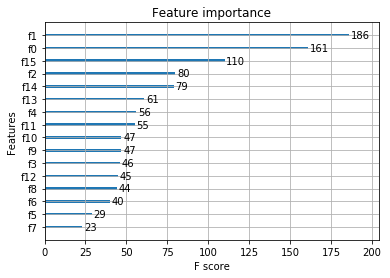

In [119]:
xgb.plot_importance(bst)

## Apply Model

In [120]:
apply_df = test_df
apply_df['shop_id']= apply_df.shop_id.astype('str')
apply_df['item_id']= apply_df.item_id.astype('str')

apply_df = test_df.merge(recent_train_df, how = "left", on = ["shop_id", "item_id"]).fillna(0.0)
apply_df.head()

,ID,shop_id,item_id,cats,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,0,5,5037,5.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [121]:
# Move to one month front
d = dict(zip(apply_df.columns[4:],list(np.array(list(apply_df.columns[4:])) - 1)))

apply_df  = apply_df.rename(d, axis = 1)

In [122]:
# preds = bst.predict(xgb.DMatrix(apply_df.iloc[:, (apply_df.columns != 'ID') & (apply_df.columns != -1)].values))
preds = bst.predict(xgb.DMatrix(apply_df.iloc[:, (apply_df.columns != 'ID') & (apply_df.columns != 19)].values))


In [123]:
print(preds[:10])

[0.2969908  0.05410463 0.63132226 0.12152329 0.05410463 0.42725486
 0.6370562  0.0612838  1.1739058  0.05410463]


In [124]:
# Normalize prediction to [0-20]
preds = list(map(lambda x: min(20,max(x,0)), list(preds)))
sub_df = pd.DataFrame({'ID':apply_df.ID,'item_cnt_month': preds })
sub_df.describe()

,ID,item_cnt_month
count,214200.000000,214200.000000
mean,107099.500000,0.257525
std,61834.358168,0.728847
min,0.000000,0.000000
25%,53549.750000,0.068179
50%,107099.500000,0.120773
75%,160649.250000,0.194828
max,214199.000000,20.000000


In [126]:
sub_df.to_csv('submissions/xg_boost4_cats_lfew_monthblocks.csv',index=False)

In [91]:
sub_df

,ID,item_cnt_month
0,0,1.789791
1,1,0.091999
2,2,1.603787
3,3,1.098495
4,4,0.091999
5,5,1.572940
6,6,3.247434
7,7,0.985335
8,8,2.918127
9,9,1.133917


In [92]:
sub_df.shape

(214200, 2)

In [93]:
sdf = pd.read_csv("xg_boost4_cats.csv")

In [94]:
sdf.shape

(214200, 2)